# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
import pandas as pd

In [2]:
from scipy.special import logit, expit
from PolicyGradientAgent import DeterministicGradientAgent
from Environment import *

In [18]:
learning_rate_theta = 1e-4
decay_rate = 0 #0.001
learning_rate_wv = 1e-4
learning_rate_wq = 1e-2
memory_size = 16
batch_size = 16
training_episodes = 900000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
prior_red_list = [3/4, 1/4]
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
agent_num=2
agent_list = []

agent = DeterministicGradientAgent(
    feature_shape=[1, 3], 
    learning_rate_theta=learning_rate_theta,
    learning_rate_wv = learning_rate_wv,
    learning_rate_wq=learning_rate_wq, 
    memory_size= memory_size, 
    batch_size=batch_size,
    beta1=beta1, 
    beta2=beta2,
    name='agent1'
)

agent.evaluation_init(pr_red_ball_red_bucket=pr_red_ball_red_bucket, pr_red_ball_blue_bucket=pr_red_ball_blue_bucket)

for i in range(agent_num):
    agent = DeterministicGradientAgent(
        feature_shape=[1, 3], 
        learning_rate_theta=learning_rate_theta,
        learning_rate_wv = learning_rate_wv,
        learning_rate_wq=learning_rate_wq, 
        memory_size= memory_size, 
        batch_size=batch_size,
        beta1=beta1, 
        beta2=beta2,
        name='agent'+str(i)
    )
    agent_list.append(agent)
    agent.evaluation_init(pr_red_ball_red_bucket=pr_red_ball_red_bucket, pr_red_ball_blue_bucket=pr_red_ball_blue_bucket)

explorer = Explorer(feature_shape=[1, 3], learning= False, init_learning_rate=3e-4, min_std=0.1)


explorer_std_list = []
explorer_h_history_list = []


for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
    # Prepare a bucket and a prediction market
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    
    for agent in agent_list:
        signal = bucket.signal()
        x = one_hot_encode(signal)
        x.append(logit(prior_red))
        mean = agent.report(x)
        pi = expit(mean)
        actor_report = [pi, 1-pi]
        explorer.set_parameters(mean=mean, std=0.3)
        e_h = explorer.report(x)
        e_pi = expit(e_h)
        explorer_report = [e_pi, 1 - e_pi]
    #     _pi = np.random.uniform() # uniform doesn't work, reason unknown.
    #     explorer_report = [_pi, 1-_pi]
        explorer_h_history_list.append([e_h, signal])
        explorer_std_list.append(explorer.std)
        pm.report(explorer_report)
        R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    

        agent.store_experience(x, e_h, R, t)
        explorer.update(R, x)

        try:
            agent.batch_update(t, algorithm= algorithm)
        except AssertionError:
            tb = traceback.format_exc()
            print(tb)


        agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    #     if explorer.learning:
    #         explorer.learning_rate_decay(epoch=t, decay_rate=0.001)
        prior_red = e_pi


  0%|          | 0/900000 [00:00<?, ?it/s]

agent0
learning_rate_theta= 0.0001
learning_rate_wv= 0.0001  learning_rate_wq= 0.01
memory_size= 16
Updating weights with regular algorithm.
agent1
learning_rate_theta= 0.0001
learning_rate_wv= 0.0001  learning_rate_wq= 0.01
memory_size= 16
Updating weights with regular algorithm.


In [19]:
reward_history_df = pd.DataFrame(
    agent.reward_history_list,
    columns=[
        'signal',
        'prior_red',
        'explorer_reward',
        'v',
        'q'
    ]
)


grad_mean_history_df = pd.DataFrame(agent.mean_gradients_history_list, columns=['red_ball', 'blue_ball', 'prior'])
mean_weights_history_df1 = pd.DataFrame(agent.mean_weights_history_list,
                                               columns=['red_weight', 'blue_weight', 'prior_weight'])
# grad_v_history_df = pd.DataFrame(grad_v_history_list, columns=['red_v', 'blue_v', 'prior_v'])
# grad_q_history_df = pd.DataFrame(grad_q_history_list, columns=['red_q', 'blue_q', 'prior_q'])

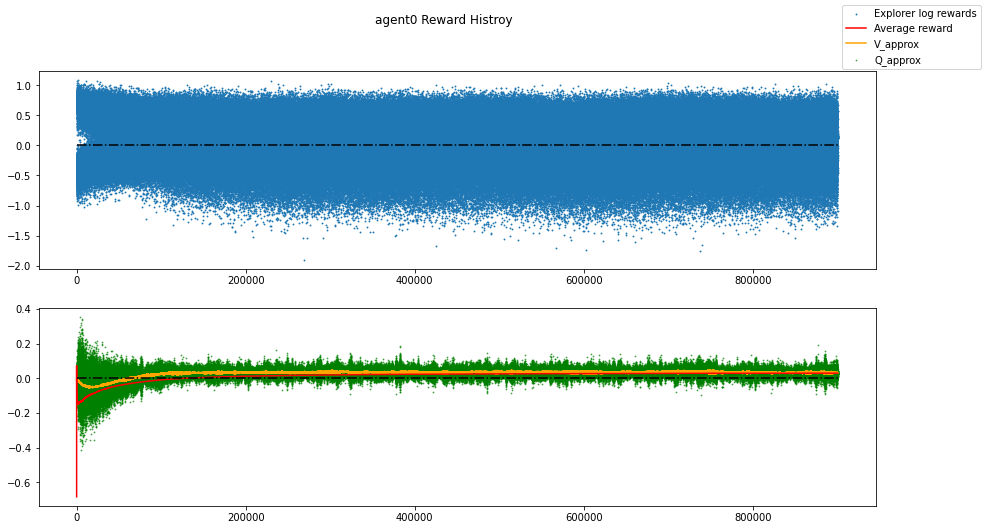

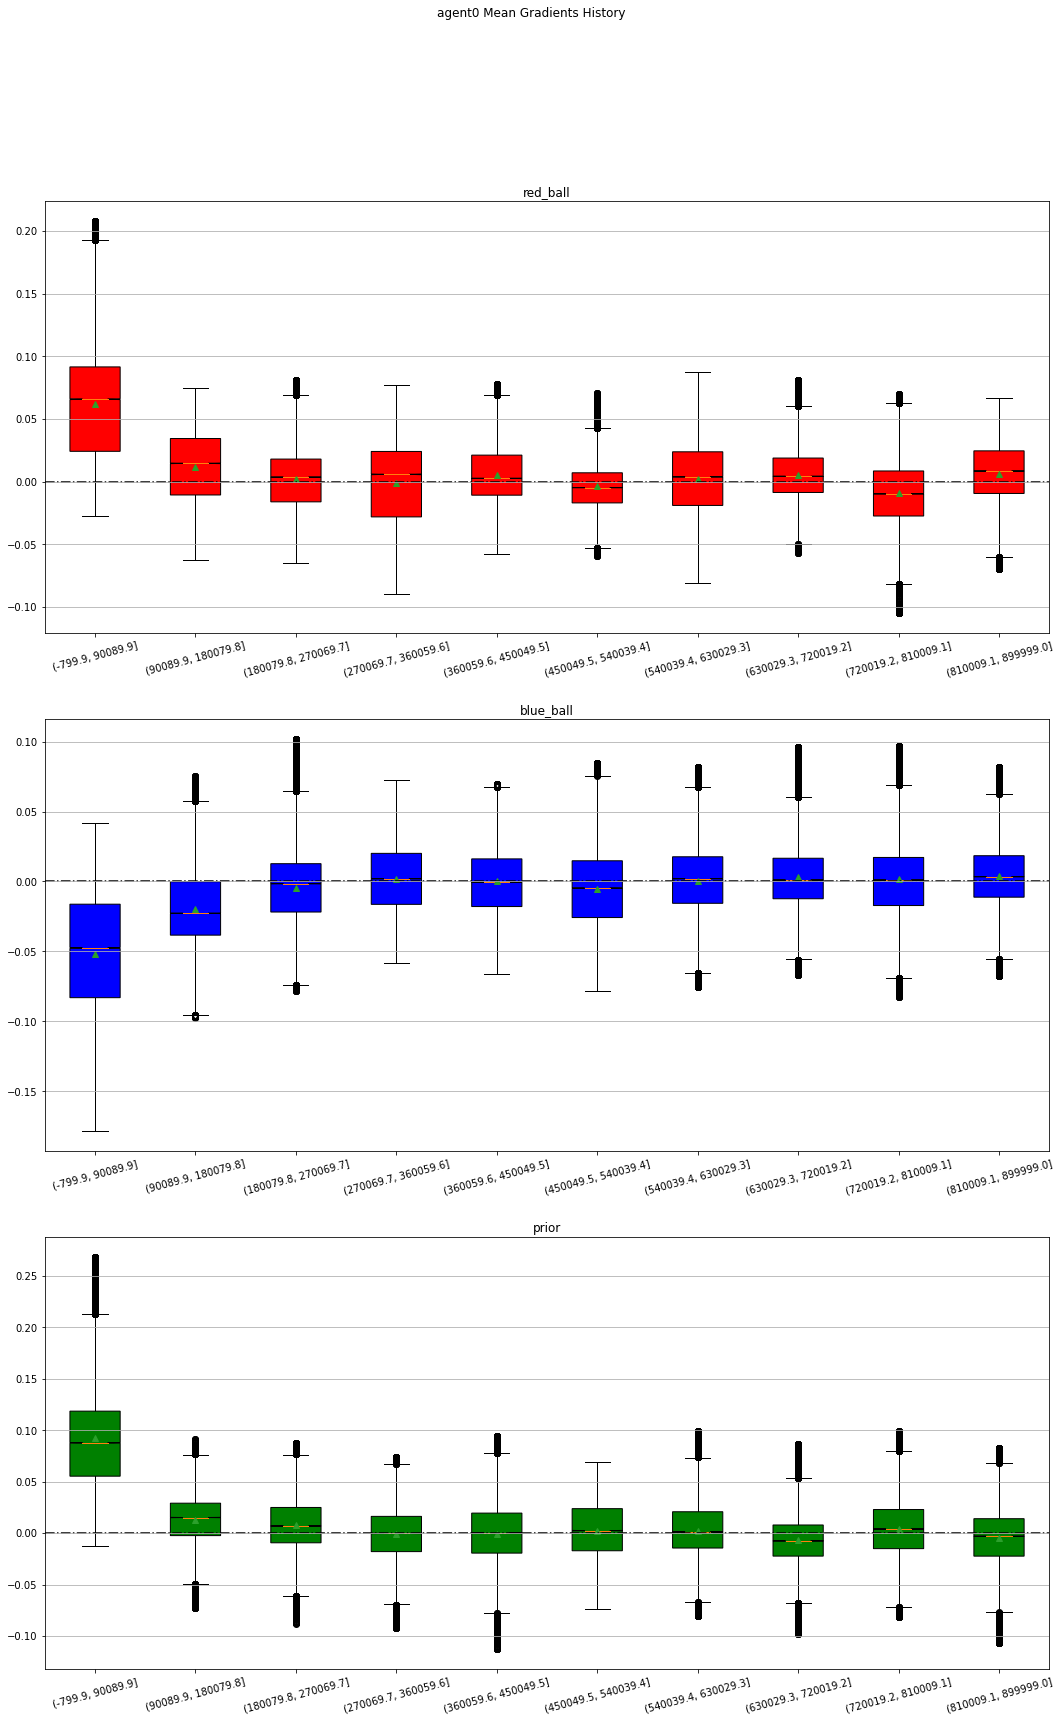

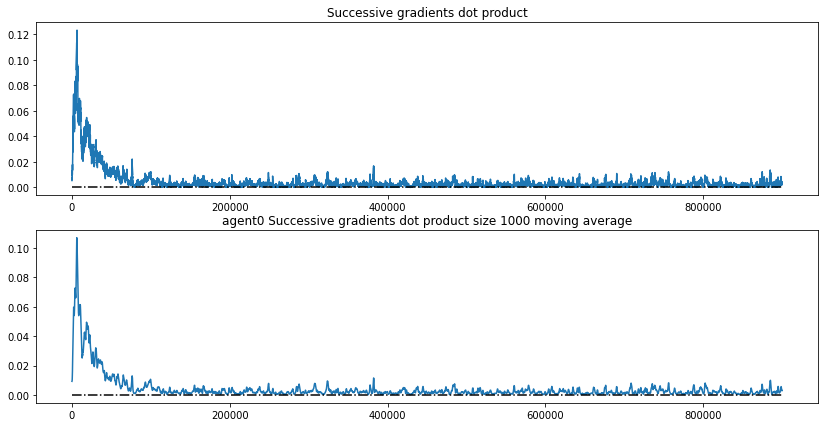

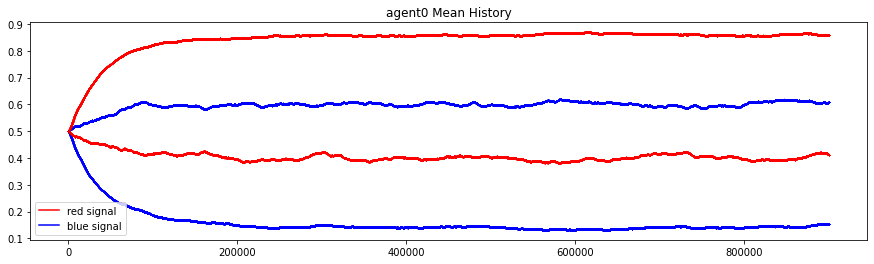

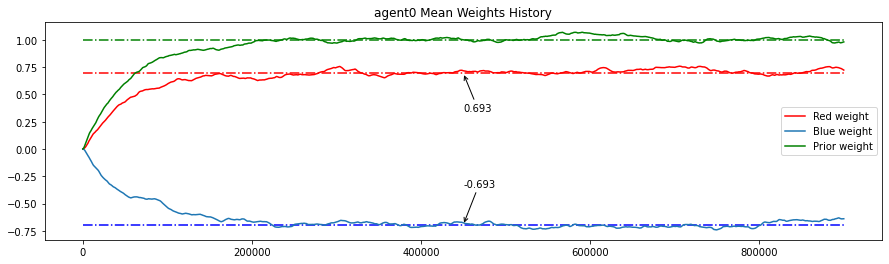

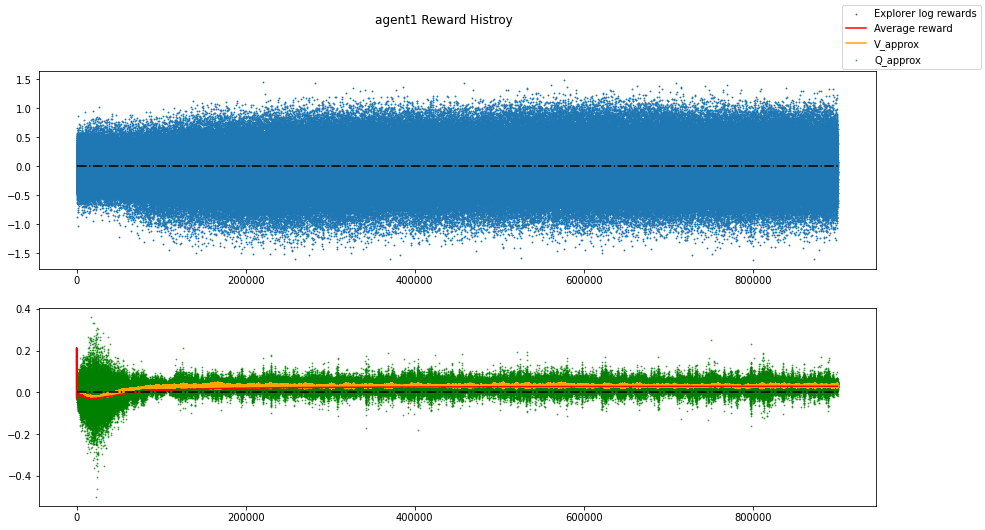

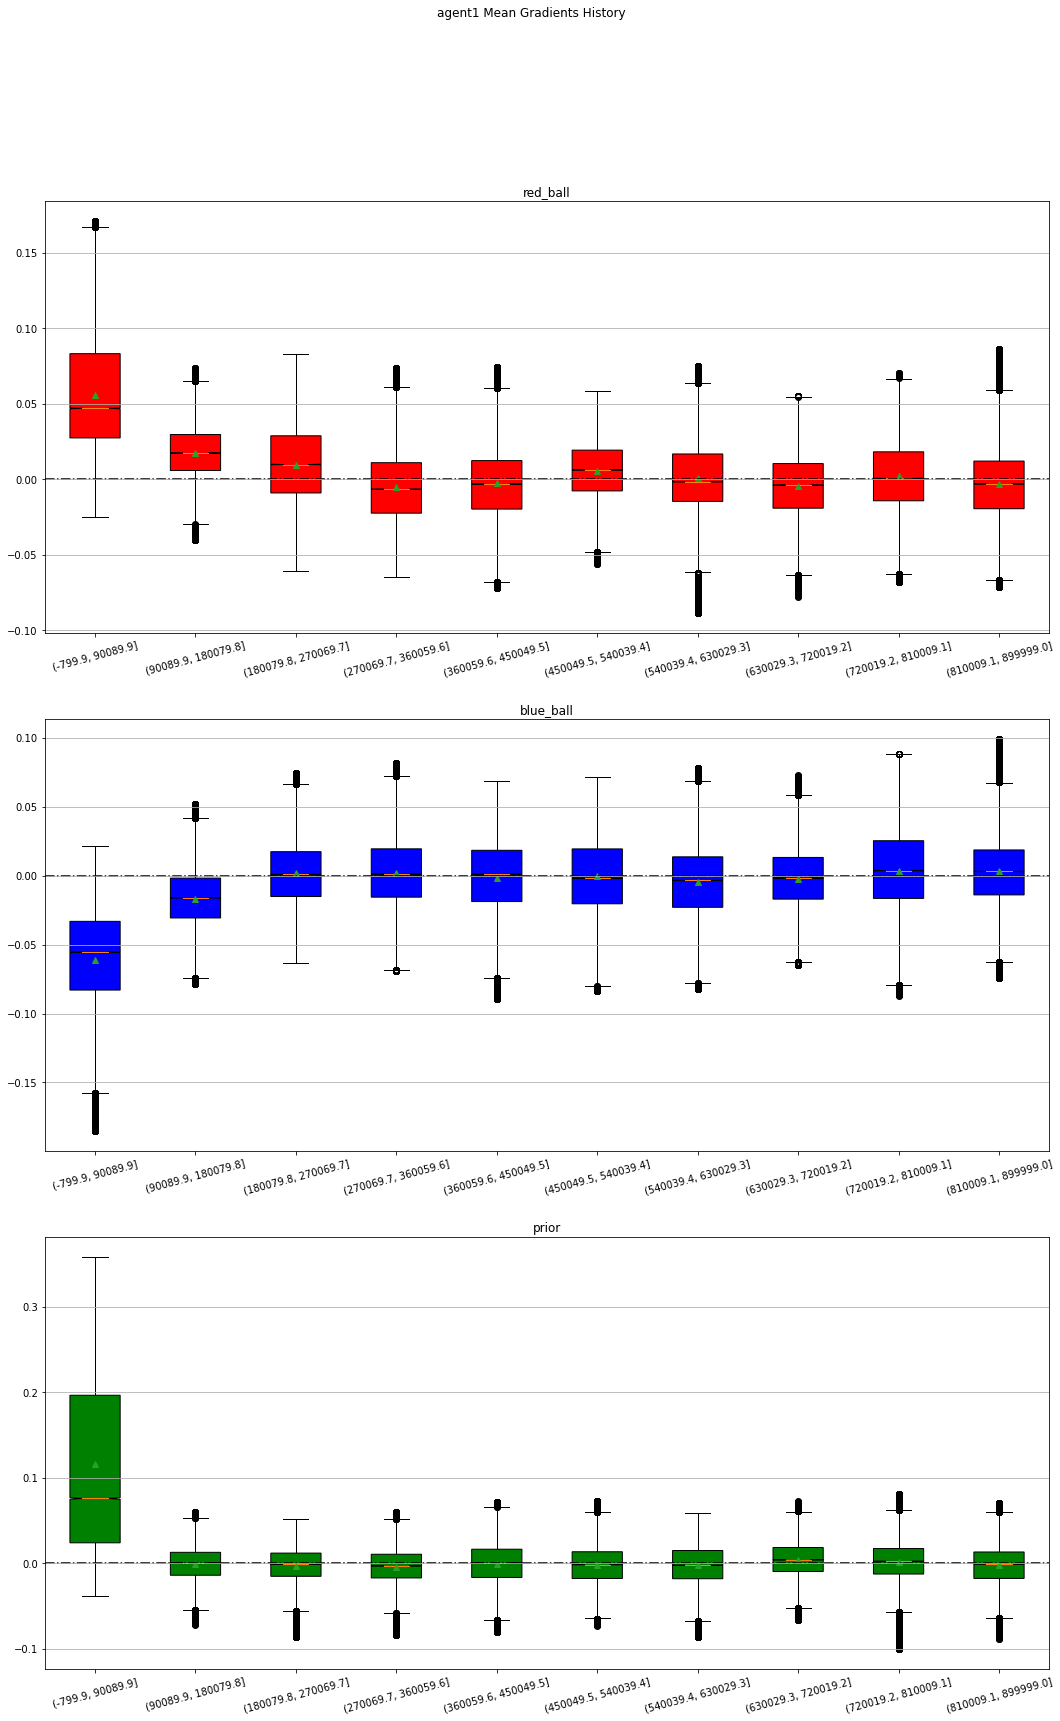

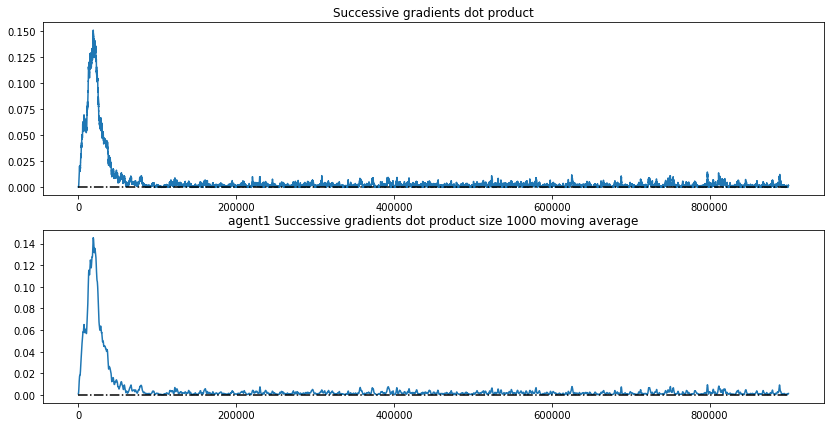

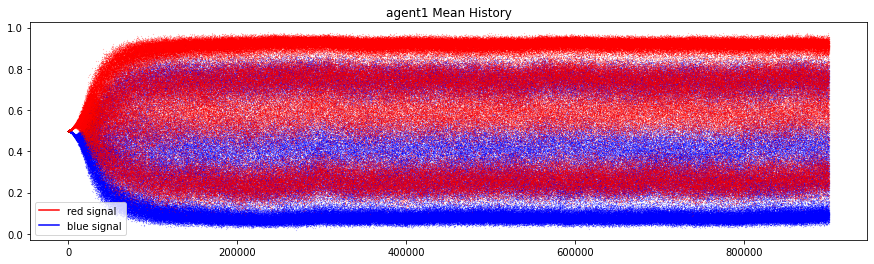

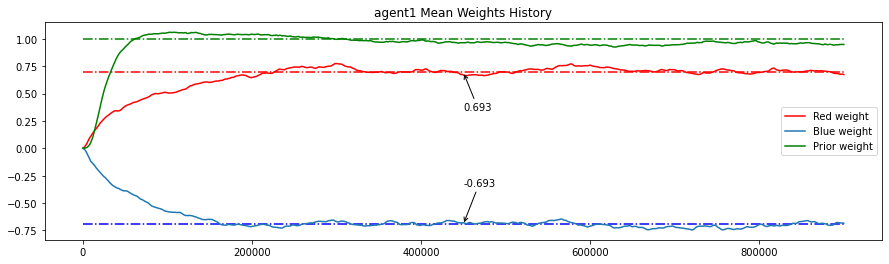

In [20]:
for agent in agent_list:
    agent.reward_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
    agent.mean_history_plot()
    agent.mean_weights_history_plot()

<AxesSubplot:>

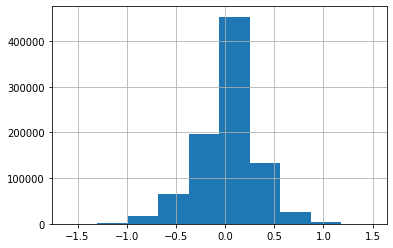

In [21]:
reward_history_df['explorer_reward'].hist()